In [1]:
# Install required packages (uncomment to install)
# !pip install -r requirements.txt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from xgboost import XGBClassifier, XGBRegressor
from flaml import AutoML
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import shap
from skopt import BayesSearchCV
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define project-specific variables
DATA_PATH = "/Users/aps/Desktop/ML-DL-Projects/01-housepriceprediction/Dataset/HousePrices.csv"  # Update with your dataset path
TARGET_COLUMN = "price"  # Update with your target column name
TASK_TYPE = "classification"  # Options: "classification" or "regression"
MODEL_SAVE_PATH = "model.pkl"

/Users/aps/Desktop/ML-DL-Projects/env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_data(file_path):
    """
    Load dataset from a given file path.
    
    Parameters:
    file_path (str): Path to the dataset (CSV, Excel, etc.)
    
    Returns:
    pandas.DataFrame: Loaded dataset
    """
    try:
        if file_path.endswith('.csv'):
            data = pd.read_csv(file_path)
        elif file_path.endswith('.xlsx'):
            data = pd.read_excel(file_path)
        else:
            raise ValueError("Unsupported file format")
        
        print("Data loaded successfully!")
        print(f"Shape: {data.shape}")
        print("\nFirst 5 rows:")
        print(data.head())
        print("\nData Info:")
        print(data.info())
        return data
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

# Load the dataset
df = load_data(DATA_PATH)
if df is None:
    raise SystemExit("Data loading failed. Exiting.")

Data loaded successfully!
Shape: (4600, 18)

First 5 rows:
                  date      price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0  2014-05-02 00:00:00   313000.0       3.0       1.50         1340      7912   
1  2014-05-02 00:00:00  2384000.0       5.0       2.50         3650      9050   
2  2014-05-02 00:00:00   342000.0       3.0       2.00         1930     11947   
3  2014-05-02 00:00:00   420000.0       3.0       2.25         2000      8030   
4  2014-05-02 00:00:00   550000.0       4.0       2.50         1940     10500   

   floors  waterfront  view  condition  sqft_above  sqft_basement  yr_built  \
0     1.5           0     0          3        1340              0      1955   
1     2.0           0     4          5        3370            280      1921   
2     1.0           0     0          4        1930              0      1966   
3     1.0           0     0          4        1000           1000      1963   
4     1.0           0     0          4        1140         


Summary Statistics:
                       date         price     bedrooms    bathrooms  \
count                  4600  4.600000e+03  4600.000000  4600.000000   
unique                   70           NaN          NaN          NaN   
top     2014-06-23 00:00:00           NaN          NaN          NaN   
freq                    142           NaN          NaN          NaN   
mean                    NaN  5.519630e+05     3.400870     2.160815   
std                     NaN  5.638347e+05     0.908848     0.783781   
min                     NaN  0.000000e+00     0.000000     0.000000   
25%                     NaN  3.228750e+05     3.000000     1.750000   
50%                     NaN  4.609435e+05     3.000000     2.250000   
75%                     NaN  6.549625e+05     4.000000     2.500000   
max                     NaN  2.659000e+07     9.000000     8.000000   

         sqft_living      sqft_lot       floors   waterfront         view  \
count    4600.000000  4.600000e+03  4600.000000  

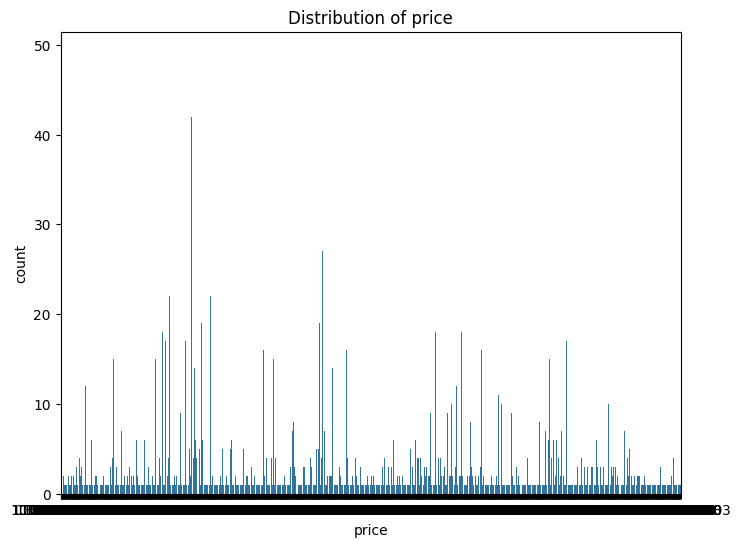

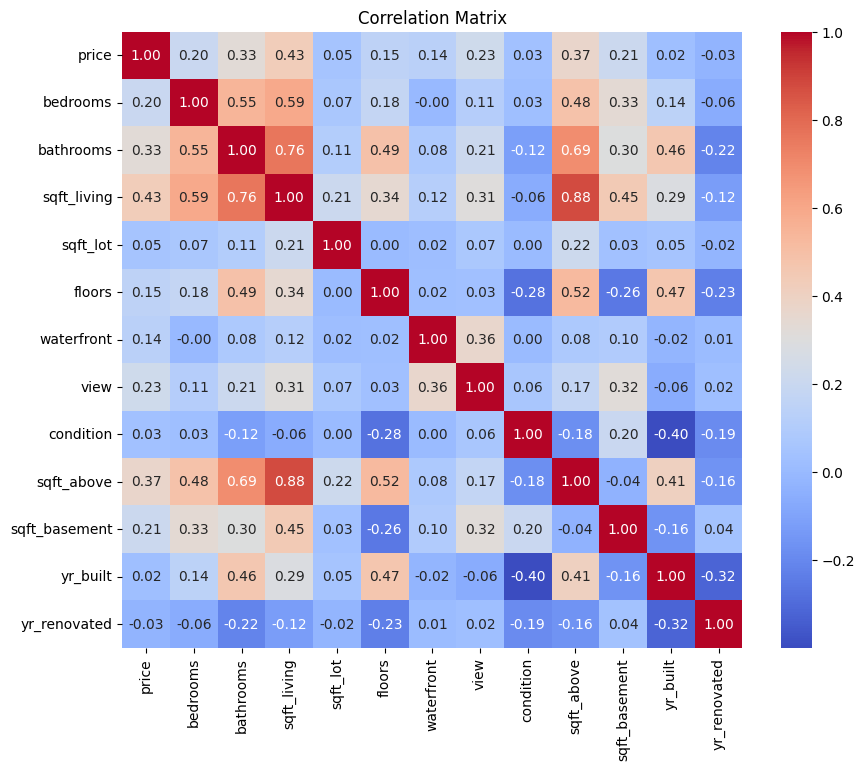

In [3]:
def perform_eda(df, target_column):
    """
    Perform exploratory data analysis on the dataset.
    
    Parameters:
    df (pandas.DataFrame): Input dataset
    target_column (str): Name of the target column
    """
    # Summary statistics
    print("\nSummary Statistics:")
    print(df.describe(include='all'))
    
    # Missing values
    print("\nMissing Values:")
    print(df.isnull().sum())
    
    # Distribution of target variable
    plt.figure(figsize=(8, 6))
    if TASK_TYPE == "classification":
        sns.countplot(x=target_column, data=df)
        plt.title(f"Distribution of {target_column}")
    else:
        sns.histplot(df[target_column], kde=True)
        plt.title(f"Distribution of {target_column} (Regression)")
    plt.show()
    
    # Correlation matrix (for numeric columns)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    plt.figure(figsize=(10, 8))
    sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title("Correlation Matrix")
    plt.show()
    
    # Pairplot for numeric features (optional, for smaller datasets)
    # sns.pairplot(df[numeric_cols])
    # plt.show()

# Perform EDA
perform_eda(df, TARGET_COLUMN)

In [4]:
def preprocess_data(df, target_column):
    """
    Preprocess the dataset (handle missing values, encode categorical variables, etc.).
    
    Parameters:
    df (pandas.DataFrame): Input dataset
    target_column (str): Name of the target column
    
    Returns:
    pandas.DataFrame: Preprocessed dataset
    """
    # Separate features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    # Handle missing values
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns
    
    # Impute numeric columns with median
    for col in numeric_cols:
        X[col].fillna(X[col].median(), inplace=True)
    
    # Impute categorical columns with mode
    for col in categorical_cols:
        X[col].fillna(X[col].mode()[0], inplace=True)
    
    # Encode categorical variables
    le = LabelEncoder()
    for col in categorical_cols:
        X[col] = le.fit_transform(X[col])
    
    # Encode target variable (for classification)
    if TASK_TYPE == "classification":
        y = le.fit_transform(y)
    
    print("Data preprocessing completed!")
    return X, y

# Preprocess data
X, y = preprocess_data(df, TARGET_COLUMN)

Data preprocessing completed!


In [5]:
def feature_engineering(X):
    """
    Perform feature engineering (e.g., creating new features, scaling).
    
    Parameters:
    X (pandas.DataFrame): Feature dataset
    
    Returns:
    pandas.DataFrame: Engineered feature dataset
    """
    # Example: Create interaction features (customize as needed)
    if 'feature1' in X.columns and 'feature2' in X.columns:
        X['feature1_feature2_interaction'] = X['feature1'] * X['feature2']
    
    # Scale numeric features
    scaler = StandardScaler()
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
    
    print("Feature engineering completed!")
    return X, scaler

# Perform feature engineering
X, scaler = feature_engineering(X)

Feature engineering completed!


In [8]:
def train_models(X, y):
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Add this line to see what's in your training set
    print(f"Number of unique classes in y_train after split: {len(np.unique(y_train))}")

    """
    Train multiple machine learning models, AutoML, and a deep learning model.
    
    Parameters:
    X (pandas.DataFrame): Features
    y (numpy.array): Target
    
    Returns:
    dict: Trained models (including AutoML and Deep Learning)
    """
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize models based on task type
    models = {}
    if TASK_TYPE == "classification":
        models['Logistic Regression'] = LogisticRegression(random_state=42)
        models['Random Forest'] = RandomForestClassifier(random_state=42)
        models['XGBoost'] = XGBClassifier(random_state=42)
    else:
        models['Linear Regression'] = LinearRegression()
        models['Random Forest'] = RandomForestRegressor(random_state=42)
        models['XGBoost'] = XGBRegressor(random_state=42)
    
    # Train manual models
    for name, model in models.items():
        model.fit(X_train, y_train)
        print(f"{name} trained successfully!")
    
    # Run AutoML
    automl_model = run_automl(X_train, y_train, TASK_TYPE, time_budget=60)
    models['AutoML'] = automl_model
    
    # Train deep learning model
    dl_model = train_deep_learning_model(X_train, y_train, TASK_TYPE)
    models['Deep Learning'] = dl_model
    
    return models, X_train, X_test, y_train, y_test

print(f"Number of unique classes in the full y dataset: {len(np.unique(y))}")

# Your existing function call
models, X_train, X_test, y_train, y_test = train_models(X, y)
# Train models
models, X_train, X_test, y_train, y_test = train_models(X, y)

Number of unique classes in the full y dataset: 1741
Number of unique classes in y_train after split: 1514
Logistic Regression trained successfully!
Random Forest trained successfully!


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [   0    1    2 ... 1511 1512 1513], got [   0    1    2 ... 1736 1737 1738]